    J’ai commencé par charger toutes les bibliothèques et dépendances nécessaires.

In [50]:
import tensorflow as tf
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

## Extraction des données

    J’ai utilisé le taux de change européen et j’ai stocké les données en temps réel dans un DataFrame pandas. J’ai utilisé la méthode to_datetime() pour convertir la chaîne (string) Datetime en objet Python Datetime. Ceci est nécessaire car les objets Datetime dans le fichier sont lus comme un objet string. Il est très facile d’effectuer des opérations telles que la différence de temps sur une chaîne plutôt que sur un objet Datetime.

In [68]:
# endpoint = 'https://min-api.cryptocompare.com/data/histoday'
# res = requests.get(endpoint + '?fsym=BTC&tsym=EUR&limit=500')
# hist = pd.DataFrame(json.loads(res.content)['Data'])
# hist = hist.set_index('time')
# hist.index = pd.to_datetime(hist.index, unit='s')
# # colonne cible
target_col = 'Close'
# # maj API, suppression des 2 colonnes string
# hist = hist.drop(['conversionType','conversionSymbol'], axis=1)
# hist.head()

In [52]:
df = pd.read_csv('ETH-EUR.csv', index_col='Date', parse_dates=True)

In [53]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-11,256.011322,273.902954,255.673492,269.811371,269.811371,7.221993e+08
2017-11-12,269.819092,273.739624,255.948730,264.072021,264.072021,1.383774e+09
2017-11-13,263.314758,281.949707,263.405121,271.556213,271.556213,8.933293e+08
2017-11-14,271.596497,290.873871,271.573212,286.394958,286.394958,9.073543e+08
2017-11-15,286.677399,289.079956,279.644714,282.937531,282.937531,6.133644e+08


## Séparation des données en 2 ensembles : training et test
    Ensuite, j’ai divisé les données en deux ensembles – un ensemble d’entrainement et un ensemble de test avec respectivement 80 % et 20 % de données. La décision prise ici l’est uniquement dans le cadre de ce tutoriel. Dans les projets réels, vous devez toujours diviser vos données en trois parties : entrainement, validation et test (par exemple 60%, 20%, 20%).

In [54]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
    
train, test = train_test_split(df, test_size=0.2)

In [55]:
print(train.size)
print(test.size)
print(df.size)

9054
2262
11316


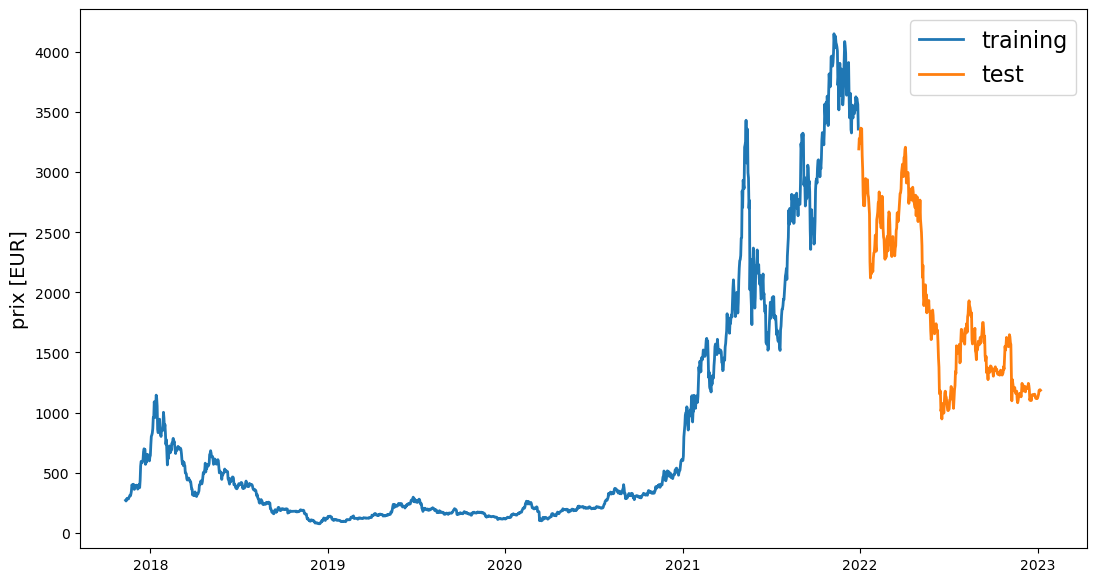

In [56]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('prix [EUR]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

    On observe une nette augmentation des prix en 2021 mais avec la crypto monnaie, il est difficile de généraliser quoi que ce soit.

Préparation des données pour le Deep Learning

    Ensuite, j’ai fait quelques fonctions pour normaliser les valeurs. La normalisation est une technique souvent appliquée dans le cadre de la préparation des données pour le Machine Learning. Le but de la normalisation est de changer les valeurs des colonnes numériques de l’ensemble de données à une échelle commune, sans déformer les différences dans les plages de valeurs.

In [58]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1
def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

    Ensuite, j’ai fait une fonction pour extraire les données des fenêtres qui sont de taille 5 chacune comme indiqué dans le code ci-dessous :

In [59]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

    J’ai continué à faire une fonction pour préparer les données dans un format qui sera ensuite introduit dans le réseau de neurones. J’ai utilisé le même concept de division des données en deux ensembles – un ensemble d’entraînement et un ensemble de test avec respectivement 80 % et 20 % de données, comme le montre le code ci-dessous :

In [60]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

# Réseau de neurones LSTM : prédiction du prix des crypto monnaies

    Il fonctionne en utilisant des portes spéciales pour permettre à chaque couche LSTM de prendre des informations à la fois des couches précédentes et de la couche actuelle. Les données passent par plusieurs portes (comme forget gate, input gate, etc.) et diverses fonctions d’activation (comme la fonction tanh, la fonction relu) et sont transmises aux cellules LSTM. Le principal avantage de cette méthode est qu’elle permet à chaque cellule LSTM de se souvenir des motifs pendant un certain temps. Il faut noter que les cellules LSTM peuvent se souvenir d’informations importantes et en même temps oublier des informations non pertinentes.
    
    Les architectures LSTM sont présentées ci-dessous :

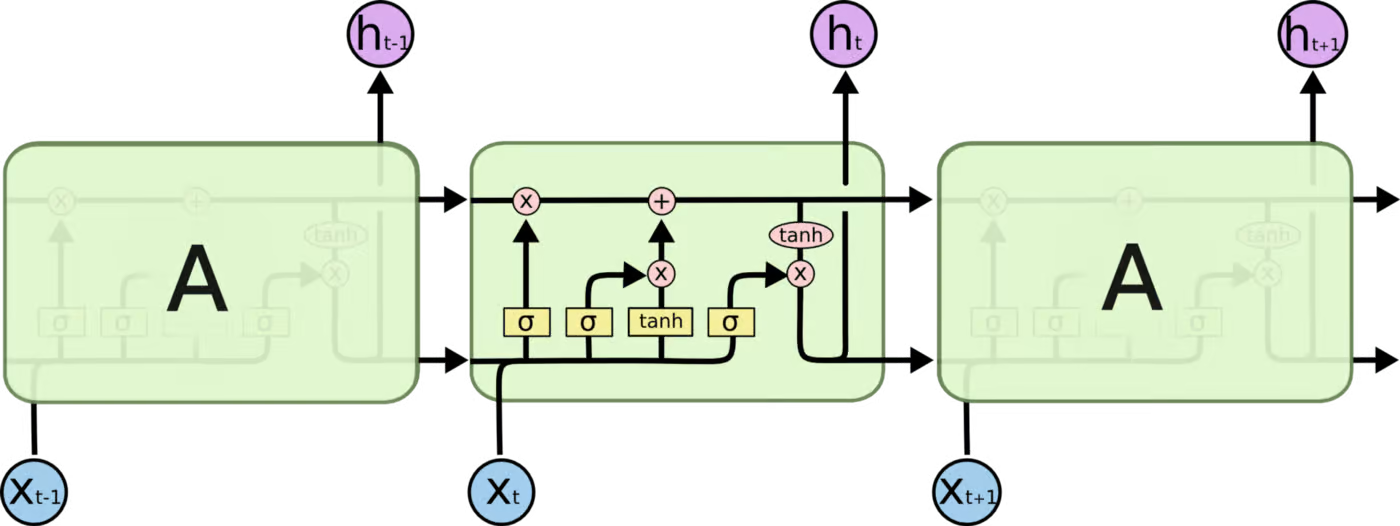

# Construction du modèle

    Maintenant, construisons le modèle. Le modèle séquentiel est utilisé pour empiler toutes les couches (entrée, cachée et sortie). Le réseau de neurones comprend une couche LSTM suivie d’une couche 20 % d’abandon et d’une couche dense avec fonction d’activation linéaire. J’ai respecté le modèle en utilisant Adam comme optimiseur et l’erreur quadratique moyenne comme fonction de perte.

In [61]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

# Paramètres du modèle

    Ensuite, j’ai défini certains des paramètres à utiliser plus tard. Ces paramètres sont les suivants : nombre aléatoire de seed, longueur de la fenêtre, taille de l’ensemble de test, nombre de neurones dans la couche LSTM, epochs, taille du lot (batch), perte, dropout et optimiseur.

In [63]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

# Entrainement du modèle

    Maintenant, entrainons le modèle en utilisant les entrées x_train et les étiquettes y_train.

In [64]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
47/47 [==============================] - 5s 7ms/step - loss: 0.0073
Epoch 2/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 3/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 4/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 5/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 6/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 7/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 8/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 9/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 10/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 11/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 12/20
47/47 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 13/20
47/47 [==============================

    J’ai utilisé l’erreur moyenne absolue (Mean Absolute Error – MAE) comme mesure d’évaluation. La raison pour laquelle j’ai choisi la MAE plutôt que l’erreur quadratique moyenne (Means Square Error – MSE) est que la MAE est plus facile à interpréter. La RMSE (Root Mean Square Error) ne décrit pas seulement l’erreur moyenne et est donc beaucoup plus difficile à comprendre. Comme nous voulons que le modèle soit facilement expliqué même à un public non technique, la MAE semble être un meilleur choix.

# Erreur Moyenne Absolue (MAE)

    Cela mesure l’ampleur moyenne des erreurs dans un ensemble de prédictions, sans tenir compte de leur direction. C’est la moyenne sur l’échantillon test des différences absolues entre les observations réelles et prédites, où toutes les différences individuelles ont le même poids.

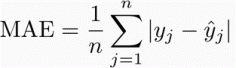

In [66]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
print("pred", preds)
mean_absolute_error(preds, y_test)

12/12 [==============================] - 0s 3ms/step
pred [ 0.0606278   0.02869466  0.05241595 -0.02767507 -0.07414256 -0.13181785
 -0.1817864  -0.1057573  -0.08496016  0.02171357  0.09366408  0.03634542
  0.07325092  0.03472911  0.00900028  0.00760778 -0.02181367 -0.0475805
 -0.07433401 -0.16342013 -0.22163539 -0.18311161 -0.18281901 -0.03048339
  0.06120519 -0.01506334  0.06972167  0.08169164  0.06513221  0.1061637
  0.09813142  0.03420395  0.01689155  0.10499095  0.07531305  0.12468857
  0.18247768  0.06407633  0.08326826  0.04058959 -0.04325175 -0.04904677
 -0.09199956 -0.02602657  0.09228937  0.07931337  0.02587237 -0.03193184
 -0.11705308 -0.13974324 -0.07969967 -0.04620095 -0.04114588  0.01885308
  0.08203581  0.07197789  0.04042811  0.12894459  0.10125431  0.08992091
  0.09612925 -0.0614035  -0.07673034 -0.09729254 -0.08155395 -0.00118587
  0.02955064  0.02213983  0.0311437   0.00746898 -0.04912514  0.01323453
  0.03034706  0.09372646  0.11061632  0.13670892  0.12180747  0.0423

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

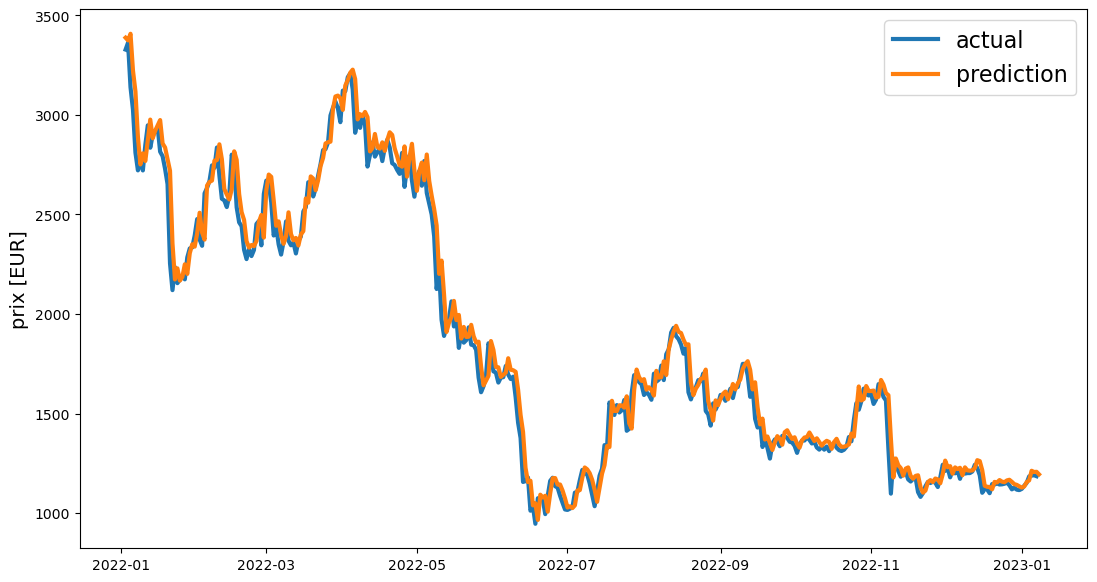

In [69]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

# Conclusion

    Dans cet article, j’ai démontré comment prédire les prix des crypto monnaies en temps réel en utilisant le réseau de neurones LSTM. J’ai suivi un processus en quatre étapes consistant à obtenir des données sur les crypto monnaies en temps réel, à préparer les données pour l’entrainement et les tests, à prédire les prix à l’aide du réseau de neurones LSTM et à visualiser les résultats de la prédiction. N’hésitez pas à jouer avec les hyper-paramètres ou à essayer différentes architectures de réseau de neurones pour obtenir de meilleurs résultats.